In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.style
matplotlib.style.use('bmh')
from matplotlib.pylab import rcParams
import seaborn as sns
from IPython.display import display
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from calendar import day_name
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

In [7]:

ticket_df = pd.read_csv('data/cinemaTicket_Ref.csv')

In [8]:
ticket_df.head(10)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.000000,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.000000,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.000000,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.000000,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.000000,15,89.982004,2018-05-05,5,2,5
5,1492,71,1050000,7,0,3,0.98,150000.000000,7,714.285714,2018-05-05,5,2,5
6,1492,163,1020000,10,0,3,7.69,102000.000000,10,130.039012,2018-05-05,5,2,5
7,1492,450,750000,5,0,3,1.57,150000.000000,5,318.471338,2018-05-05,5,2,5
8,1492,51,750000,11,0,2,0.95,68181.818182,11,1157.894737,2018-05-05,5,2,5
9,1492,522,600000,4,0,3,1.55,150000.000000,4,258.064516,2018-05-05,5,2,5


In [9]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


In [10]:

ticket_df.shape

(142524, 14)

In [11]:
ticket_df.isnull().sum()

film_code         0
cinema_code       0
total_sales       0
tickets_sold      0
tickets_out       0
show_time         0
occu_perc       125
ticket_price      0
ticket_use        0
capacity        125
date              0
month             0
quarter           0
day               0
dtype: int64

In [12]:

pd.DataFrame(data = [ticket_df.isna().sum()/ticket_df.shape[0]*100],
             index=["Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Null (%)
film_code,0.000000
cinema_code,0.000000
total_sales,0.000000
tickets_sold,0.000000
tickets_out,0.000000
show_time,0.000000
occu_perc,0.087705
ticket_price,0.000000
ticket_use,0.000000
capacity,0.087705


In [13]:

ticket_df.dropna(inplace=True)
ticket_df.isnull().sum()

print(f"Dataset has {ticket_df.duplicated().sum()} duplicated data")

Dataset has 104 duplicated data


In [14]:
ticket_df.drop_duplicates(keep='first')

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4


In [15]:
def duplicate(df, column):
    if len(df[df[column].duplicated()]) == 0:
        print(f'STATUS: There are no duplicate values in the column of "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column of "{column}"')

duplicate(ticket_df,'film_code')

duplicate(ticket_df,'cinema_code')

ticket_df['date'] = pd.to_datetime(ticket_df["date"],errors='coerce')

cols = ['film_code','cinema_code','date']
ticket_df['id']=ticket_df[cols].apply(lambda row:'_'.join(row.values.astype(str)), axis=1)

STATUS: There are 142351 duplicate values in the column of "film_code"
STATUS: There are 142155 duplicate values in the column of "cinema_code"


In [16]:

ticket_df.head(2)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,id
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,1492_304_2018-05-05 00:00:00
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,1492_352_2018-05-05 00:00:00


In [17]:
ticket_df = ticket_df[['id'] + [a for a in ticket_df.columns if a != 'id'] ]

In [18]:
ticket_df.tail(2)

,id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
142522,1569_529_2018-11-04 00:00:00,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4
142523,1569_486_2018-11-04 00:00:00,1569,486,250000,5,0,1,1.79,50000.0,5,279.329609,2018-11-04,11,4,4


In [19]:

ticket_df.drop_duplicates('id',inplace=True)

duplicate(ticket_df,'id')

STATUS: There are no duplicate values in the column of "id"


In [20]:
unique_films = ticket_df['film_code'].nunique()
unique_cinemas = ticket_df['cinema_code'].nunique()
print(f"{unique_films} unique films.")
print(f"{unique_cinemas} unique cinemas ")

48 unique films.
244 unique cinemas 


In [21]:
mean = ticket_df['total_sales'].mean()
print(f'mean is {mean}')
std = ticket_df['total_sales'].std()
print(f'standard deviation is {std}')
if std>mean:
    print(f"standard deviation is {std/mean} higher than mean")

#simple function to carry out the emperical formula
def empirical_rule(n=1 ,rt = False):
    UB = mean + (n* std)
    LB = mean - (n * std)
    if rt:
        return UB 
    print(f"valid range for {n} std : {LB} <= Total Sales <= {UB}")

empirical_rule(1) 
empirical_rule(2) 
empirical_rule(3) 

mean is 12338325.170870375
standard deviation is 30627056.35678718
standard deviation is 2.4822701568195638 higher than mean
valid range for 1 std : -18288731.185916804 <= Total Sales <= 42965381.52765755
valid range for 2 std : -48915787.542703986 <= Total Sales <= 73592437.88444473
valid range for 3 std : -79542843.89949116 <= Total Sales <= 104219494.24123192


In [22]:
UB = empirical_rule(3,rt=True)
ticket_df2=ticket_df[ticket_df['total_sales']<= UB]
print(f"Filtered total sales values <= {UB}")
mean =ticket_df2['total_sales'].mean()
print(f"mean = {mean}")
std = ticket_df2['total_sales'].std()
print(f"std  = {std}")
print(f"standard deviation is {std/mean} higher than mean")

Filtered total sales values <= 104219494.24123192
mean = 9431057.905127015
std  = 14980741.718226833
standard deviation is 1.5884476448907008 higher than mean


In [23]:
def aggregate_period(df, period,column, w_mean = False):
    freq = df.date.dt.to_period(period)
    if w_mean == False:
        s = df.groupby(freq).agg({'total_sales': ['sum']})
        s.columns = ['met']
    else:
        s = df.groupby(freq).agg({column: ['mean']})
        s.columns = [f'met']
    s.reset_index(level=0, inplace=True)
    s.date= s.date.astype(str)
    return s

In [24]:
def aggregate_period_weekday(df,column, w_mean= False):
    freq = df['date'].dt.day_name()
    if w_mean == False:
        s = df.groupby(freq).agg({'total_sales': ['sum']})
        s.columns = ['met']
    else:
        s = df.groupby(freq).agg({column: ['mean']})
        s.columns = [f'met']
    s.reset_index(level=0, inplace=True)
    s.date= s.date.astype(str)
    d = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    s = s.set_index('date').reindex(d).reset_index()
    return s


In [25]:

def viz(df, title,n):
    date = df['date'][-n:] 
    count_period =df['met'][-n:] 

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time Frequency')
    plt.ylabel("Total Sales")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 3.5)
    
    for x,y in zip(date,count_period):
        label = "{:.2e}".format(y)
        plt.annotate((label), 
                     (x,y), 
                     textcoords="offset points",
                     xytext=(2,10), 
                     ha='center' , fontsize=12)
    overall_mean = count_period.mean()
    plt.fill_between(date, count_period,overall_mean,where=(count_period>overall_mean),alpha=0.10, interpolate=True, color='Green')
    plt.fill_between(date, count_period,overall_mean,where=(count_period<overall_mean),alpha=0.10, interpolate=True, color='DarkRed')
    plt.legend(['Sales', 'above average', 'below average'], prop={'size': 8})
    plt.xticks(rotation=90)
    return plt.show()

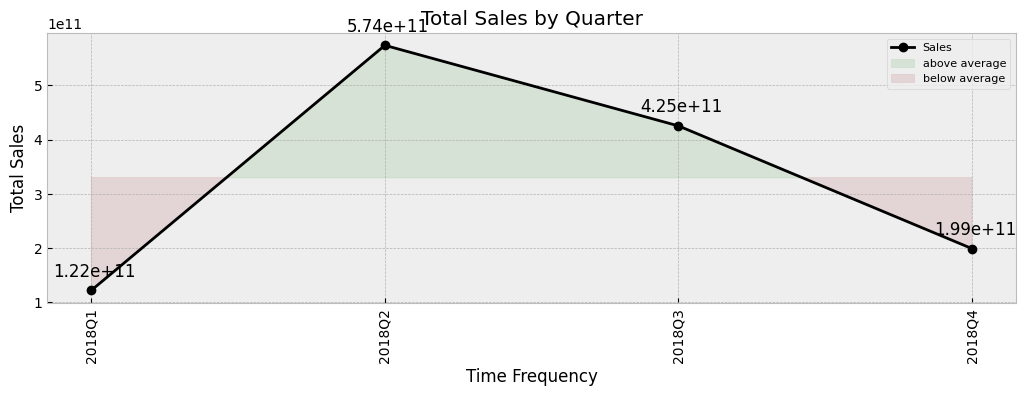

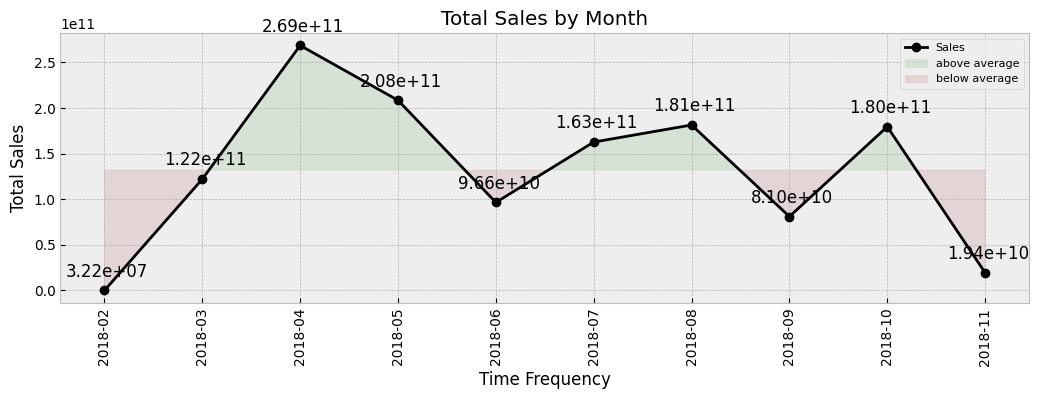

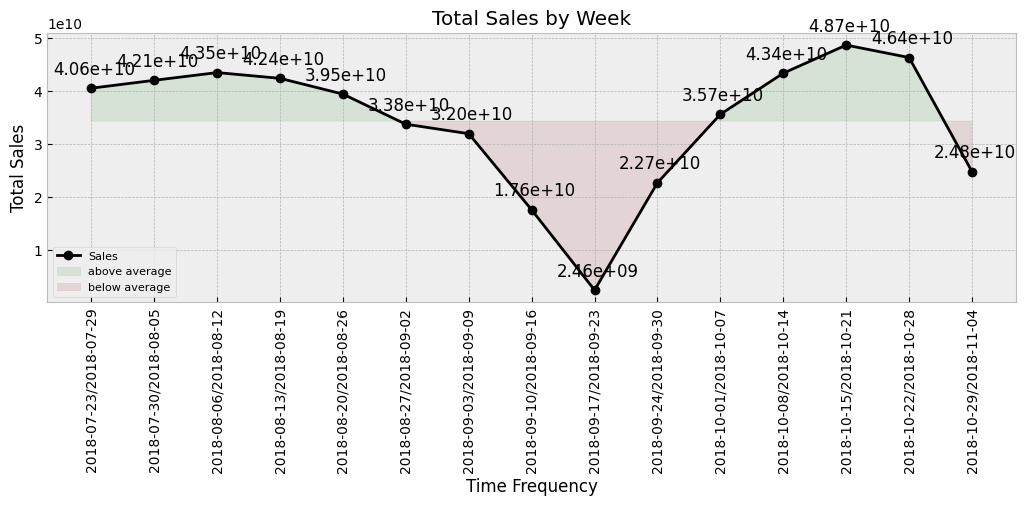

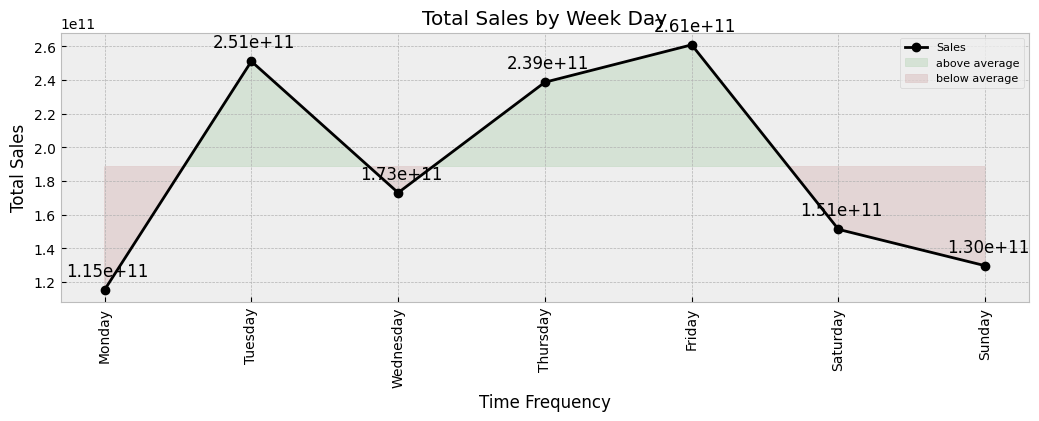

In [26]:

q = aggregate_period(ticket_df2, 'q','na')
m = aggregate_period(ticket_df2, 'm','na')
w = aggregate_period(ticket_df2, 'w','na')
W = aggregate_period_weekday(ticket_df2,'na')
viz(q ,"Total Sales by Quarter",25)
viz(m ,"Total Sales by Month",25)
viz(w ,"Total Sales by Week",15)
viz(W ,"Total Sales by Week Day",15)

In [27]:
df = aggregate_period(ticket_df2, 'd','na')
df.set_index('date',inplace=True)
df.rename(columns={'met':'Total_Sales'},inplace=True)
df.sample(10)

,Total_Sales
date,
2018-04-12,11698252500
2018-08-19,3892945000
2018-09-08,3292790000
2018-08-01,5401284996
2018-04-24,12296929995
2018-09-15,1149309998
2018-09-02,2973775000
2018-08-13,4518539996
2018-04-06,11401619992


In [28]:
def differencing(df,date, order=1):

    df[date]=pd.to_datetime(df[date],errors='coerce')
    df=df.set_index(date)

    print(f'The order of the transform is {order}')


    if order == 1:
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)

        df['target_order_dt']=df['total_sales_log'] - df['t_minus_1']


    elif order == 2:
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)
        df['first_order_dt']=df['total_sales_log'] - df['t_minus_1'] #returns 1st order
        df['first_order_dt_minus_1']=df['first_order_dt'].shift(periods=1)
        df['target_order_dt']=df['first_order_dt'] - df['first_order_dt_minus_1'] # returns 2nd order dt

    elif order == 3:
        
        df['t_minus_1']=df['total_sales_log'].shift(periods=1)
        df['first_order_dt']=df['total_sales_log'] - df['t_minus_1'] # returns 1st order
        df['first_order_dt_minus_1']=df['first_order_dt'].shift(periods=1)
        df['second_order_dt']=df['first_order_dt'] - df['first_order_dt_minus_1'] # returns 2nd order
        df['second_order_dt_minus_1']=df['second_order_dt'].shift(periods=1)
        df['target_order_dt']=df['second_order_dt'] - df['second_order_dt_minus_1'] # returns 3rd order

    else:
        raise Exception("Order for this particular problem shoud be <=3 ")
    

    
    
    df[['target_order_dt']].plot(figsize=(15,8))
    plt.title(f'Total Sales After Differencing with Order {order} Against Time')
    plt.xlabel('Time')
    plt.ylabel("Total Sales After Differencing")
    plt.show()

    return df




In [29]:

df['total_sales_log'] = np.log(df.Total_Sales)
df.head()

,Total_Sales,total_sales_log
date,,
2018-02-21,32030000,17.282184
2018-02-23,180000,12.100712
2018-03-14,1870938994,21.349706
2018-03-15,3309334994,21.920013
2018-03-16,4043241998,22.120313


The order of the transform is 1


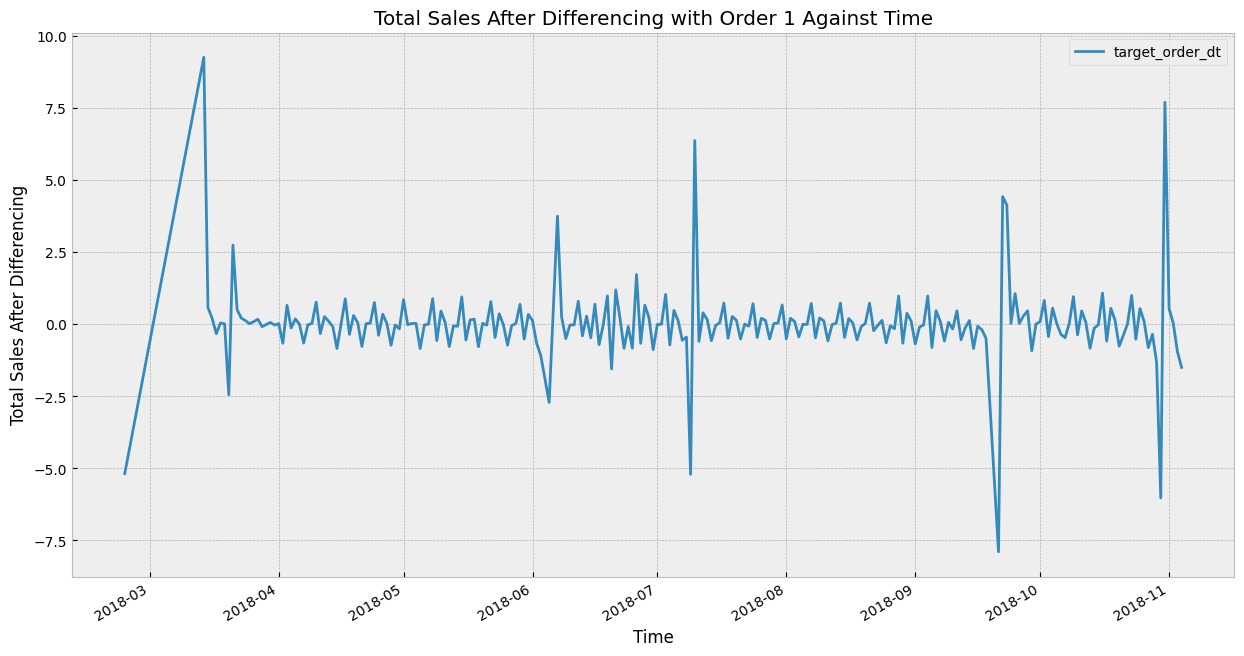

,Total_Sales,total_sales_log,t_minus_1,target_order_dt
date,,,,
2018-02-21,32030000,17.282184,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471
2018-03-14,1870938994,21.349706,12.100712,9.248994
2018-03-15,3309334994,21.920013,21.349706,0.570307
2018-03-16,4043241998,22.120313,21.920013,0.200300
...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493
2018-11-01,7722309998,22.767379,22.231552,0.535828
2018-11-02,7970860000,22.799058,22.767379,0.031679


The order of the transform is 2


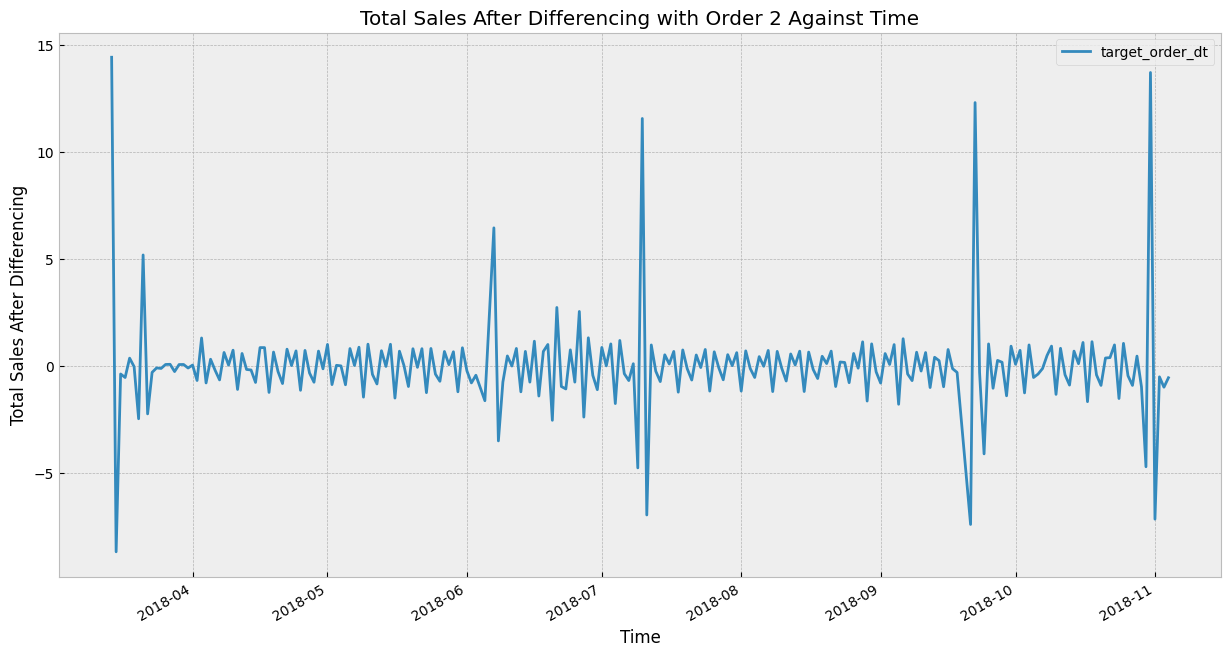

,Total_Sales,total_sales_log,t_minus_1,first_order_dt,first_order_dt_minus_1,target_order_dt
date,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007
...,...,...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493,-6.028757,13.717249
2018-11-01,7722309998,22.767379,22.231552,0.535828,7.688493,-7.152665
2018-11-02,7970860000,22.799058,22.767379,0.031679,0.535828,-0.504149


The order of the transform is 3


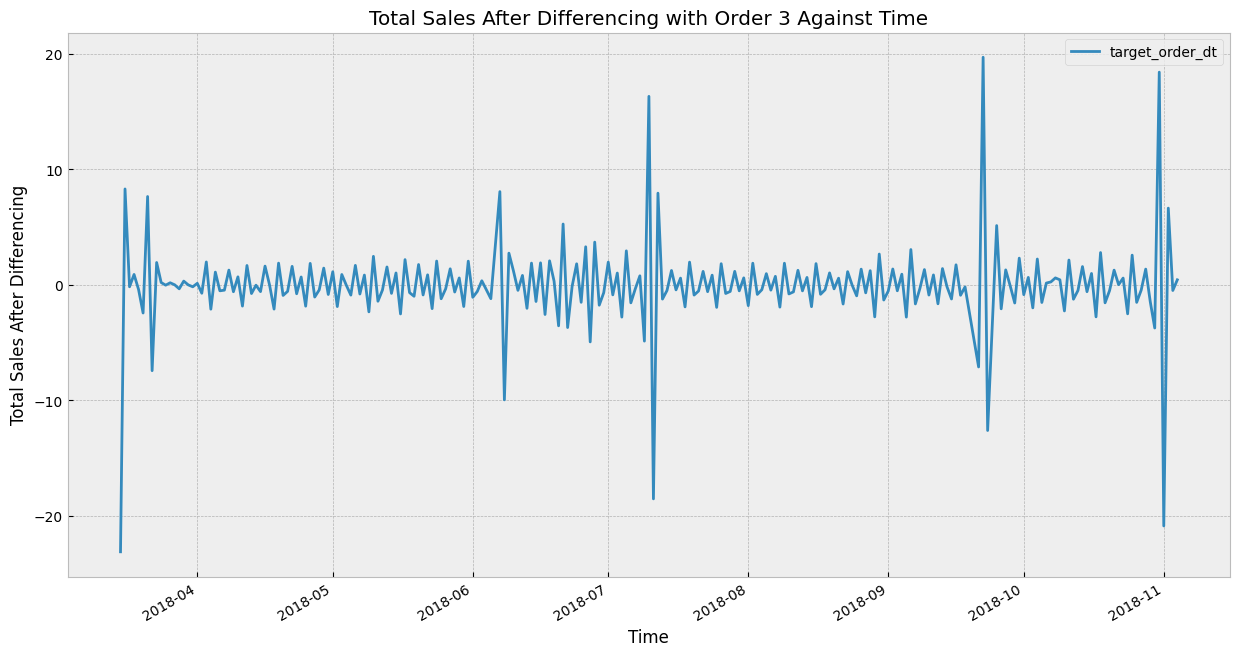

,Total_Sales,total_sales_log,t_minus_1,first_order_dt,first_order_dt_minus_1,second_order_dt,second_order_dt_minus_1,target_order_dt
date,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680
...,...,...,...,...,...,...,...,...
2018-10-31,4518978000,22.231552,14.543059,7.688493,-6.028757,13.717249,-4.704206,18.421456
2018-11-01,7722309998,22.767379,22.231552,0.535828,7.688493,-7.152665,13.717249,-20.869914
2018-11-02,7970860000,22.799058,22.767379,0.031679,0.535828,-0.504149,-7.152665,6.648516


In [30]:
df_temp = df.reset_index()

df1_dt = differencing(df_temp, 'date', order=1)
display(df1_dt)

df2_dt = differencing(df_temp, 'date', order=2)
display(df2_dt)

df3_dt = differencing(df_temp, 'date', order=3)
display(df3_dt)

In [31]:
def adf_calc(df, target):
    timeseries = df[target]
    result = adfuller(timeseries,autolag='AIC') #the adf function
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('Critical Value: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags used: %f' %result[2])
    print('Threshold Values:')
    for key, value in result[4].items(): #critical value dict
        print('%s: %.3f' % (key, value))
adf_calc(df , 'Total_Sales')

Critical Value: -2.252671
p-value: 0.187687
Lags used: 14.000000
Threshold Values:
1%: -3.461
5%: -2.875
10%: -2.574


In [32]:

df2 = df1_dt.dropna()
print("check stationarity of order 1")
adf_calc(df2, 'target_order_dt')

check stationarity of order 1
Critical Value: -11.317874
p-value: 0.000000
Lags used: 5.000000
Threshold Values:
1%: -3.459
5%: -2.874
10%: -2.574


In [33]:
# Forecasting With Machine Learning

In [34]:
df2.columns




Index(['Total_Sales', 'total_sales_log', 't_minus_1', 'target_order_dt'], dtype='object')

In [35]:
method_list=[] #going to hold the method
algorithm_list = [] #specific algorithm
rmse_list =[] # root mean squared error
mse_list = [] #mean squared error
mae_list = [] #mean absolute error
r2_list = []
d = {
    'Method': method_list,
    'Algorithm':algorithm_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

In [36]:

def get_data():
    df2 = df.copy()
    df2['lag_1'] =  df2['Total_Sales'].shift(periods=1)
    df2['lag_2'] =  df2['Total_Sales'].shift(periods=2)
    df2['lag_3'] =  df2['Total_Sales'].shift(periods=3)
    df2['lag_4'] =  df2['Total_Sales'].shift(periods=4)
    df2['lag_5'] =  df2['Total_Sales'].shift(periods=5)
    df2 = df2.dropna()
    df2.drop('total_sales_log', axis=1 ,inplace=True)
    return df2

In [37]:
def train_test_split(df2, n_test):
    x_train = df2.iloc[:-n_test , 1:]  # removing last 30 days and total_sales col
    y_train = df2.iloc[:-n_test , :1] # removing last 30 days and only taking total_Sales col
    x_test = df2.iloc[-n_test: , 1:]  # considering last 30 days without total sales
    y_test = df2.iloc[-n_test: , :1]  # total sales of last 30 days

    return x_train, y_train, x_test, y_test

In [38]:
def model_train(x_train, y_train, model, model_params):
    if model == 'XGB':
        print("Using XGB model")
        model = model_params #specified parameters
    elif model == 'RFR':
        print("Using RFR model")
        model = model_params
    else:
        print("Using Linear Regression model")
        model = model_params

    # fit model
    model = model.fit(x_train, y_train)

   
    y_train_pred = model.predict(x_train)
    return model , y_train_pred

In [39]:
def test_preds(model_fit,x_test):
    ypred = model_fit.predict(x_test)
    return ypred

In [40]:
def get_metrics_ml(model_fit,x_test,y_test,model):
    ypred = test_preds(model_fit,x_test)
    #compute metrics
    mse = mean_squared_error(y_test,ypred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,ypred)
    r2 = r2_score(y_test,ypred)

    method = 'Machine Learning'
    algorithm = model

    # append values in the list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


    result = pd.DataFrame(d)
    return result

In [41]:
df2 = get_data()

x_train, y_train, x_test, y_test = train_test_split(df2, 30)

model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=100))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=100)')

model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=200))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=200)')

model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=300)')

model_fit, y_train_pred_XGB = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGBRegressor')


model_fit, y_train_pred_XGB = model_train(x_train, y_train, 'LR', LinearRegression())
result = get_metrics_ml(model_fit, x_test, y_test, 'Linear Regression')

result

Using RFR model
Using RFR model
Using RFR model
Using XGB model
Using Linear Regression model


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Machine Learning,RFR(n_estimators=100),7.716221e+18,2.777809e+09,2.402536e+09,0.201658
1,Machine Learning,RFR(n_estimators=200),7.470949e+18,2.733304e+09,2.339553e+09,0.227035
2,Machine Learning,RFR(n_estimators=300),7.442448e+18,2.728085e+09,2.335873e+09,0.229984
3,Machine Learning,XGBRegressor,7.929780e+18,2.815987e+09,2.313002e+09,0.179563
4,Machine Learning,Linear Regression,9.677848e+18,3.110924e+09,2.918928e+09,-0.001297


In [42]:
x_cv = df2.iloc[: , 1:]
y_cv = df2.iloc[: , :1]
rmodel =  RandomForestRegressor(random_state=0, n_estimators=300)
scores = cross_val_score(rmodel, x_cv, y_cv, cv=5)
scores
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

xgbmod = XGBRegressor(objective='reg:squarederror', random_state=0)
x_scores = cross_val_score(xgbmod,x_cv, y_cv, cv=5)
x_scores
print("%0.3f accuracy with a standard deviation of %0.3f" % (x_scores.mean(), x_scores.std()))

0.385 accuracy with a standard deviation of 0.301
0.235 accuracy with a standard deviation of 0.384


In [43]:
def get_forecast_date(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    forecast_date = df.index[-1] + pd.DateOffset(days=1)
    return forecast_date

In [44]:
def append_row(df):
    new_row = np.flip(np.append(df.Total_Sales[-5:].values, np.nan))
    forecast_date = get_forecast_date(df)
    df.loc[forecast_date] = new_row
    return df, forecast_date

In [45]:
def model_forecast(model_fit, df):
    new_row = np.flip(df.Total_Sales[-5:].values) #last 5 sales
    ypred = model_fit.predict([new_row.tolist()])
    df, forecast_date = append_row(df)
    df.at[forecast_date, 'Total_Sales'] = ypred #the ypred will
    return df

In [46]:
def model_forecast_n(n, model_fit, df):
    for i in range(n):
        df = model_forecast(model_fit, df)
    return df

In [47]:
df2 = get_data()


In [48]:
forecast_date = get_forecast_date(df2)
print(forecast_date)
x_train, y_train, x_test, y_test = train_test_split(df2, 30)
model_fit, y_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
df2 = model_forecast_n(30, model_fit, df2)
df2[-30:]

2018-11-05 00:00:00
Using RFR model


,Total_Sales,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,
2018-11-05,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09,7.722310e+09,4.518978e+09
2018-11-06,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09,7.722310e+09
2018-11-07,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09,7.970860e+09
2018-11-08,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08,3.065780e+09
2018-11-09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09,6.829850e+08
2018-11-10,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09,4.691958e+09
2018-11-11,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09,5.167676e+09
2018-11-12,4.942827e+09,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09,5.289846e+09
2018-11-13,5.767961e+09,4.942827e+09,5.120131e+09,5.303138e+09,5.425749e+09,6.518204e+09


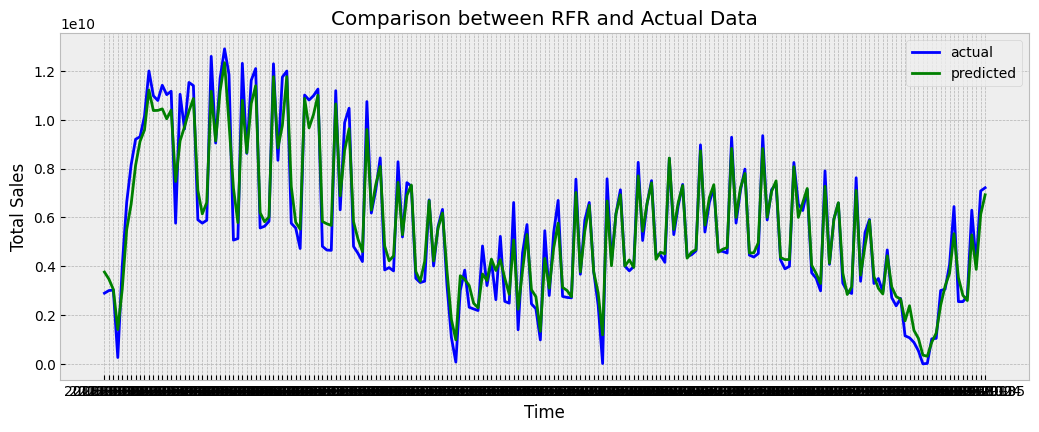

In [49]:
actual = get_data().iloc[:-30 ]
index_list = actual.index.tolist()
prediction = y_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between RFR and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual.Total_Sales, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='g' )
plt.legend()

